In [1]:
#import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import pearsonr
import itertools
import patsy
from patsy import ModelDesc

#disable future warning
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:
def has_intercept(model):
    return "Intercept" in model.model.exog_names

def term_names(model):

    exog_names = model.model.exog_names
    predictors = [name for name in exog_names if name != "Intercept"]
    if has_intercept(model):
        return ["(Intercept)"] + predictors
    else:
        return predictors


def mygvif(mod):
    '''
    rebuild the vif.lm function from the R car package in Python
    check GVIF (Generalized Variance Inflation Factor) to assess multicollinearity in the model
    parameter: 
        mod - linear model fitted by the statsmodels library
    '''
    names = term_names(mod) 
    X_full = mod.model.exog
    intercept = has_intercept(mod)
    
    if intercept:
        names = names[1:]
        X = X_full[:, 1:]
        assign_X = mod.model.data.design_info.term_name_slices.copy()
        del assign_X["Intercept"]
    else:
        raise ValueError("No intercept: (G)VIFs may not be sensible.")
    
    R = np.corrcoef(X, rowvar=False)
    detR = np.linalg.det(R)
    
    formula_str = mod.model.formula
    md = ModelDesc.from_formula(formula_str)
    predictors = sorted({var.name() for term in md.rhs_termlist for var in term.factors})
    
    try:
        terms_all = mod.model.data.design_info.term_names
        terms = [t for t in terms_all if t not in ("Intercept", "const")]
    except AttributeError:
        terms = []
    term_vars = [term.split(":") for term in terms]
    
    vifs = pd.DataFrame(0, index=predictors, columns=["GVIF", "Df", "GVIF^(1/(2*Df))"])
    vifs["Interacts With"] = ""
    vifs["Other Predictors"] = ""
    
    all_cols = list(range(X.shape[1]))
    
    assign_vector = None
    if assign_X is not None:
        terms_order = terms
        assign_vector = [None] * X.shape[1]
        for term_index, term in enumerate(terms_order):
            if term in assign_X:
                s = assign_X[term]
                cols = list(range(s.start - 1, s.stop - 1)) if intercept else list(range(s.start, s.stop))
                for col in cols:
                    assign_vector[col] = term_index
    else:
        assign_vector = None
    
    for predictor in predictors:
        which_terms = [predictor in tv for tv in term_vars]
        related_str = ":".join([terms[i] for i, flag in enumerate(which_terms) if flag])
        if related_str:
            related_vars = list(set(related_str.split(":")))
        else:
            related_vars = []
        
        interacts_with = [v for v in related_vars if v != predictor]
        if interacts_with:
            vifs.loc[predictor, "Interacts With"] = ", ".join(interacts_with)
        else:
            vifs.loc[predictor, "Interacts With"] = "--  "
        
        unrelated = [p for p in predictors if p not in related_vars]
        
        if len(unrelated) > 0 and assign_vector is not None:
            unrelated_terms_flags = [any(u in tv for u in unrelated) for tv in term_vars]
            unrelated_term_indices = [i for i, flag in enumerate(unrelated_terms_flags) if flag]
            cols_flagged = [j for j in all_cols if assign_vector[j] in unrelated_term_indices]
            columns = [j for j in all_cols if j not in cols_flagged]
            sub_R = R[np.ix_(columns, columns)]
            complement = [j for j in all_cols if j not in columns]
            sub_R_comp = R[np.ix_(complement, complement)]
            gvif = np.linalg.det(sub_R) * np.linalg.det(sub_R_comp) / detR
            vifs.loc[predictor, "Other Predictors"] = ", ".join(unrelated)
        else:
            columns = all_cols
            gvif = 1
            vifs.loc[predictor, "Other Predictors"] = "--  "
        
        p_val = len(columns)
        vifs.loc[predictor, "GVIF"] = gvif
        vifs.loc[predictor, "Df"] = p_val
        vifs.loc[predictor, "GVIF^(1/(2*Df))"] = gvif**(1/(2*p_val)) if p_val > 0 else np.nan
    
    if all(vifs["Df"] == 1):
        print("VIFs computed for predictors")
        return vifs["GVIF"]
    else:
        print("GVIFs computed for predictors")
        return vifs


In [3]:
def chart_correlation(data,
                      labels=None,
                      hist_bins=20,
                      marker_size=20,
                      alpha=0.6,
                      figsize=(12, 12),
                      font_size=12
                      ):
    '''
    plot the correlation between variables
    parameter: 
        data - num data
        labels - a list of variable names
        hist_bins - number of bins for histograms on the diagonal
        marker_size - size of scatter plot markers
        alpha - transparency level for scatter plot
        figsize - figure size
        font_size - font size
    '''
    if labels is None:
        labels = [f"Var{i}" for i in range(data.shape[1])]

    num_vars = data.shape[1]
    fig, axes = plt.subplots(num_vars, num_vars, figsize=figsize)

    for i in range(num_vars):
        for j in range(num_vars):
            ax = axes[i, j]
            if i == j:
                ax.hist(data[:, i], bins=hist_bins,
                        color='lightgrey', edgecolor='black')
                ax.set_title(labels[i], fontsize=font_size)
            elif i > j:
                ax.scatter(data[:, j], data[:, i], s=marker_size, alpha=alpha)
                if i == num_vars - 1:
                    ax.set_xlabel(labels[j], fontsize=font_size)
                if j == 0:
                    ax.set_ylabel(labels[i], fontsize=font_size)
            else:
                r, p = pearsonr(data[:, j], data[:, i])
                ax.text(0.5, 0.5, f"r = {r:.2f}\np = {p:.2e}",
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=font_size)
                ax.set_xticks([])
                ax.set_yticks([])
            ax.tick_params(labelsize=font_size * 0.8)

    plt.tight_layout()
    plt.show()

In [4]:
#question 1

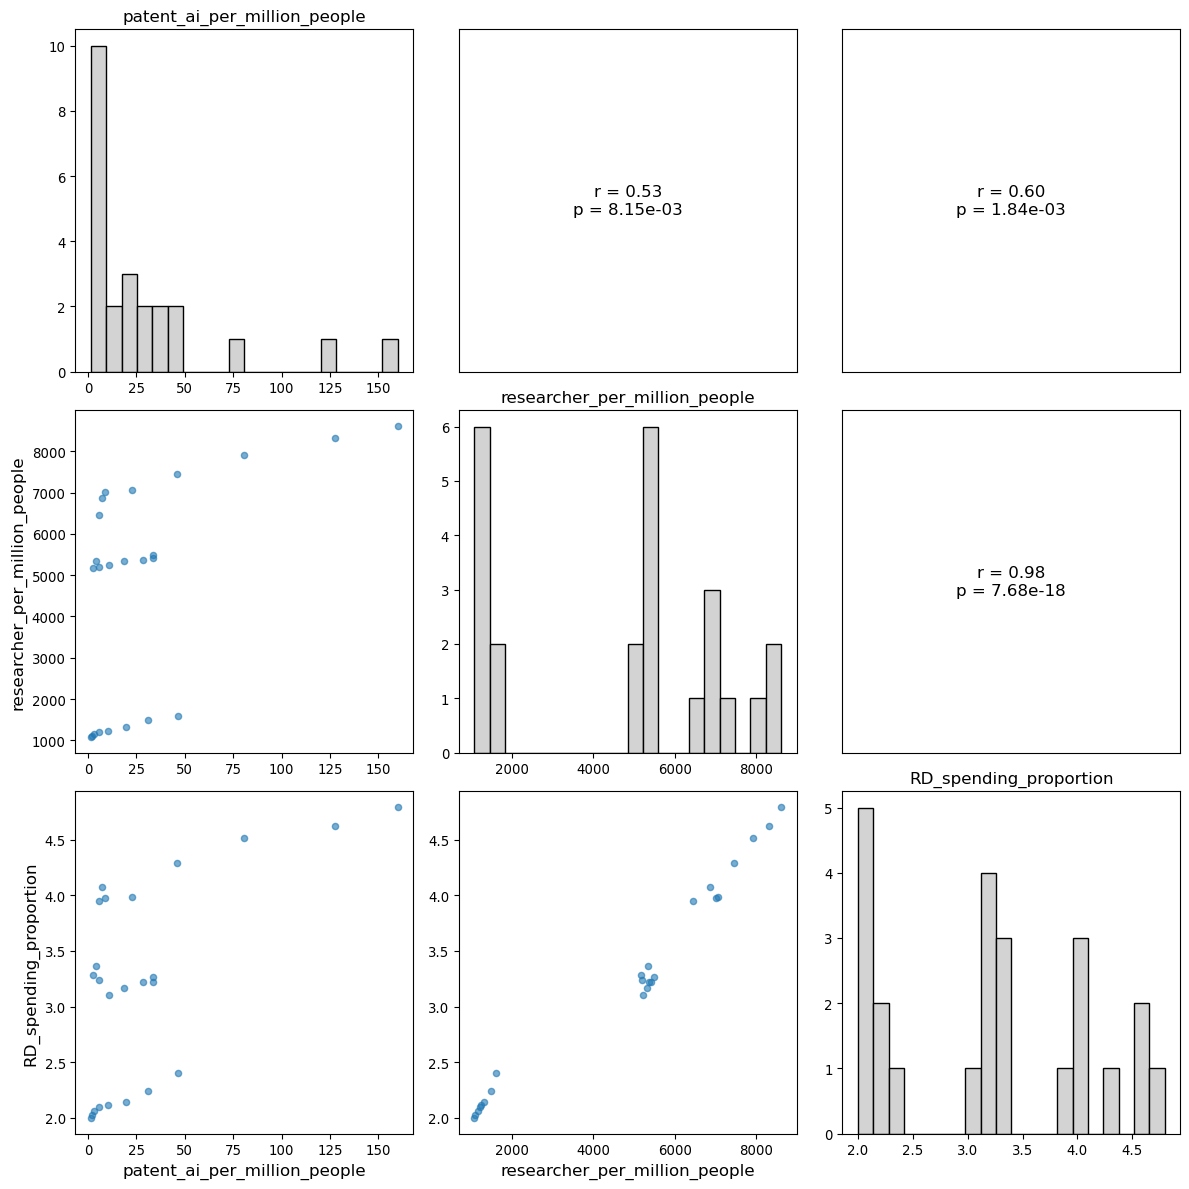

In [5]:
#read data
question_1_data = pd.read_csv("Group_27_Data_1.csv")
question_1_data['Entity'] = question_1_data['Entity'].astype(
        'category')
#select num type data
num_question_1_data = question_1_data[['patent_ai_per_million_people',
                                           'researcher_per_million_people', 'RD_spending_proportion']].to_numpy()
#plot the correlation between variables
chart_correlation(num_question_1_data, [
                      'patent_ai_per_million_people', 'researcher_per_million_people', 'RD_spending_proportion'])

In [6]:
def fit_model(data, response, predictors):
    '''
    fit model
    '''
    formula = f"{response} ~ {' + '.join(predictors)}"
    return smf.ols(formula, data=data).fit()
    
def stepAIC_backward(data, response, predictors):
    '''
    backward stepAIC find best model
    '''
    def fit_model(X):
        formula = f"{response} ~ {' + '.join(X)}"
        return smf.ols(formula, data=data).fit()

    def get_aic(model):
        return model.aic

    best_model = fit_model(predictors)
    best_aic = get_aic(best_model)
    best_predictors = predictors[:]
    for r in range(len(predictors) - 1, 0, -1):
        for subset in itertools.combinations(predictors, r):
            model = fit_model(subset)
            if get_aic(model) < best_aic:
                best_aic = get_aic(model)
                best_model = model
                best_predictors = list(subset)
    return best_model
    
def stepAIC_both(data, response, predictors, start_predictors=None):
    '''
    both side stepAIC find best model (R default way) 
    '''
    def fit_model(predictor_list):
        if predictor_list:
            formula = f"{response} ~ {' + '.join(predictor_list)}"
        else:
            formula = f"{response} ~ 1"
        return smf.ols(formula, data=data).fit()

    def get_aic(model):
        return model.aic

    if start_predictors is None:
        current_predictors = predictors[:]
    else:
        current_predictors = start_predictors[:]

    current_model = fit_model(current_predictors)
    current_aic = get_aic(current_model)
    improved = True

    while improved:
        improved = False
        candidate_models = []
        if current_predictors:
            for pred in current_predictors:
                new_predictors = current_predictors.copy()
                new_predictors.remove(pred)
                candidate_model = fit_model(new_predictors)
                candidate_aic = get_aic(candidate_model)
                candidate_models.append((candidate_aic, new_predictors, candidate_model, 'remove', pred))
        for pred in predictors:
            if pred not in current_predictors:
                new_predictors = current_predictors.copy() + [pred]
                candidate_model = fit_model(new_predictors)
                candidate_aic = get_aic(candidate_model)
                candidate_models.append((candidate_aic, new_predictors, candidate_model, 'add', pred))
        if candidate_models:
            best_candidate = min(candidate_models, key=lambda x: x[0])
            best_aic, best_predictors, best_model, action, changed_pred = best_candidate
            if best_aic < current_aic:
                current_aic = best_aic
                current_predictors = best_predictors
                current_model = best_model
                improved = True
    return current_model

In [7]:
def gen_plots(model):
    '''
    generate four residual diagnostic plots to evaluate the model's quality
    parameter: 
        mod - linear model fitted by the statsmodels library
    '''
    fitted_values = model.fittedvalues
    residuals = model.resid
    standardized_residuals = residuals / np.std(residuals)
    influence = model.get_influence()
    leverage = influence.hat_matrix_diag
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Residuals vs Fitted
    axes[0, 0].scatter(fitted_values, residuals, alpha=0.7)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel("Fitted Values")
    axes[0, 0].set_ylabel("Residuals")
    axes[0, 0].set_title("Residuals vs Fitted")

    # Q-Q
    sm.qqplot(standardized_residuals, line='45', ax=axes[0, 1])
    axes[0, 1].set_title("Normal Q-Q")

    # Scale-Location
    sqrt_standardized_residuals = np.sqrt(np.abs(standardized_residuals))
    axes[1, 0].scatter(
        fitted_values, sqrt_standardized_residuals, alpha=0.7, edgecolors='k')
    lowess_scale = lowess(sqrt_standardized_residuals, fitted_values)
    axes[1, 0].plot(lowess_scale[:, 0], lowess_scale[:, 1],
                    color='red', linewidth=2)
    axes[1, 0].set_xlabel("Fitted Values")
    axes[1, 0].set_ylabel("√|Standardized Residuals|")
    axes[1, 0].set_title("Scale-Location")

    # Residuals vs Leverage
    axes[1, 1].scatter(leverage, standardized_residuals,
                       alpha=0.7, edgecolors='k')
    lowess_lev = lowess(standardized_residuals, leverage)
    axes[1, 1].plot(lowess_lev[:, 0], lowess_lev[:, 1],
                    color='red', linewidth=2) 
    axes[1, 1].set_xlabel("Leverage")
    axes[1, 1].set_ylabel("Standardized Residuals")
    axes[1, 1].set_title("Residuals vs Leverage")

    plt.tight_layout()
    plt.show()


<<<<Model for patent_ai_per_million_people>>>>
--------------------------------------------
                                 OLS Regression Results                                 
Dep. Variable:     patent_ai_per_million_people   R-squared:                       0.950
Model:                                      OLS   Adj. R-squared:                  0.943
Method:                           Least Squares   F-statistic:                     126.8
Date:                          Fri, 07 Mar 2025   Prob (F-statistic):           3.51e-13
Time:                                  09:29:22   Log-Likelihood:                -86.195
No. Observations:                            24   AIC:                             180.4
Df Residuals:                                20   BIC:                             185.1
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                  

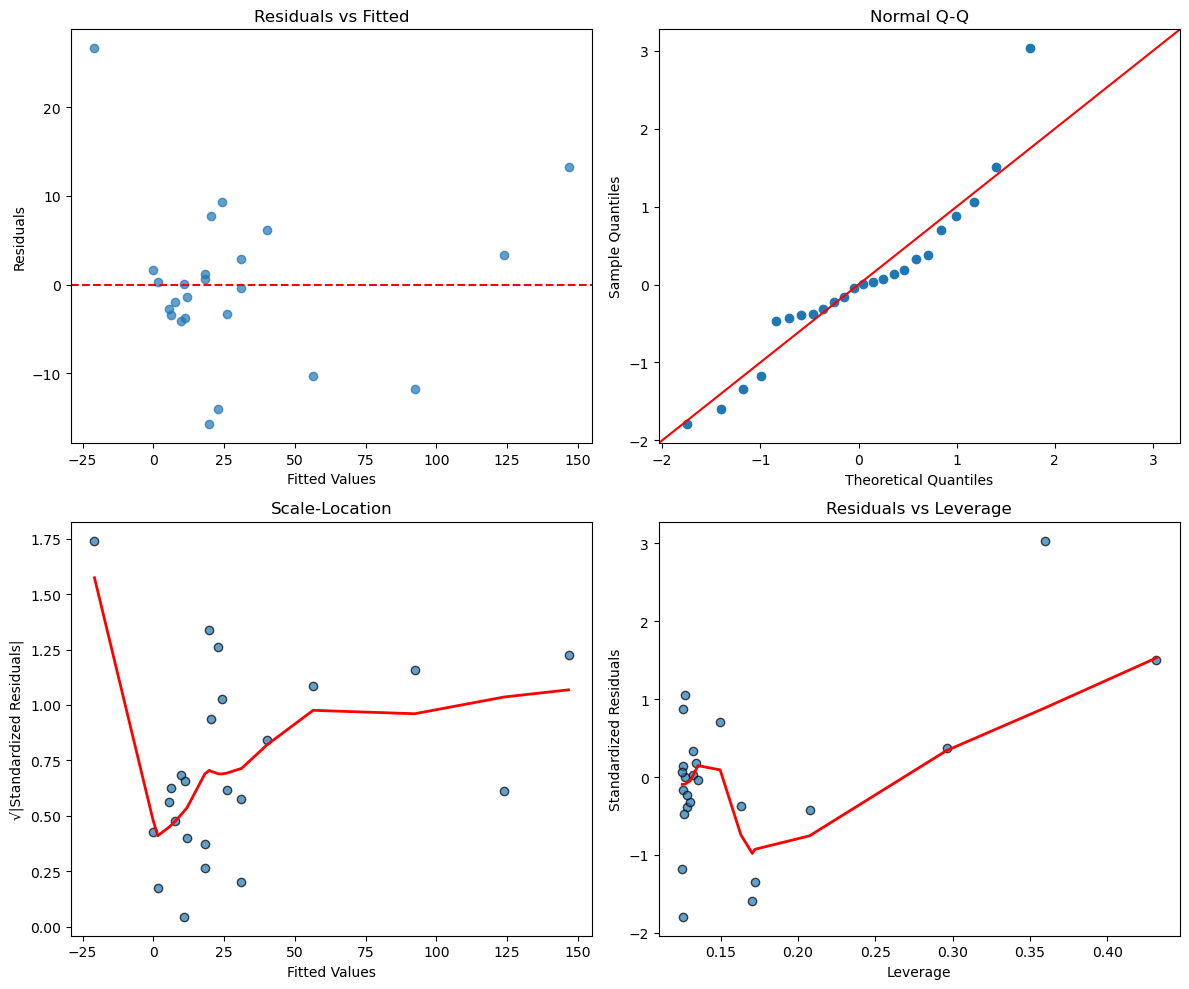

GVIFs computed for predictors
                                   GVIF  Df  GVIF^(1/(2*Df)) Interacts With  \
Entity                         37.44408   2         2.473693           --     
researcher_per_million_people  37.44408   1         6.119157           --     

                                            Other Predictors  
Entity                         researcher_per_million_people  
researcher_per_million_people                         Entity  


In [8]:
predictors = ['RD_spending_proportion', 'researcher_per_million_people', 'Entity']
#fit model for question 1
model_question_1 = stepAIC_backward(
        question_1_data, 'patent_ai_per_million_people', predictors)
print("<<<<Model for patent_ai_per_million_people>>>>")
print("--------------------------------------------")
print(model_question_1.summary())
gen_plots(model_question_1)
print(mygvif(model_question_1))

In [9]:
#question 2

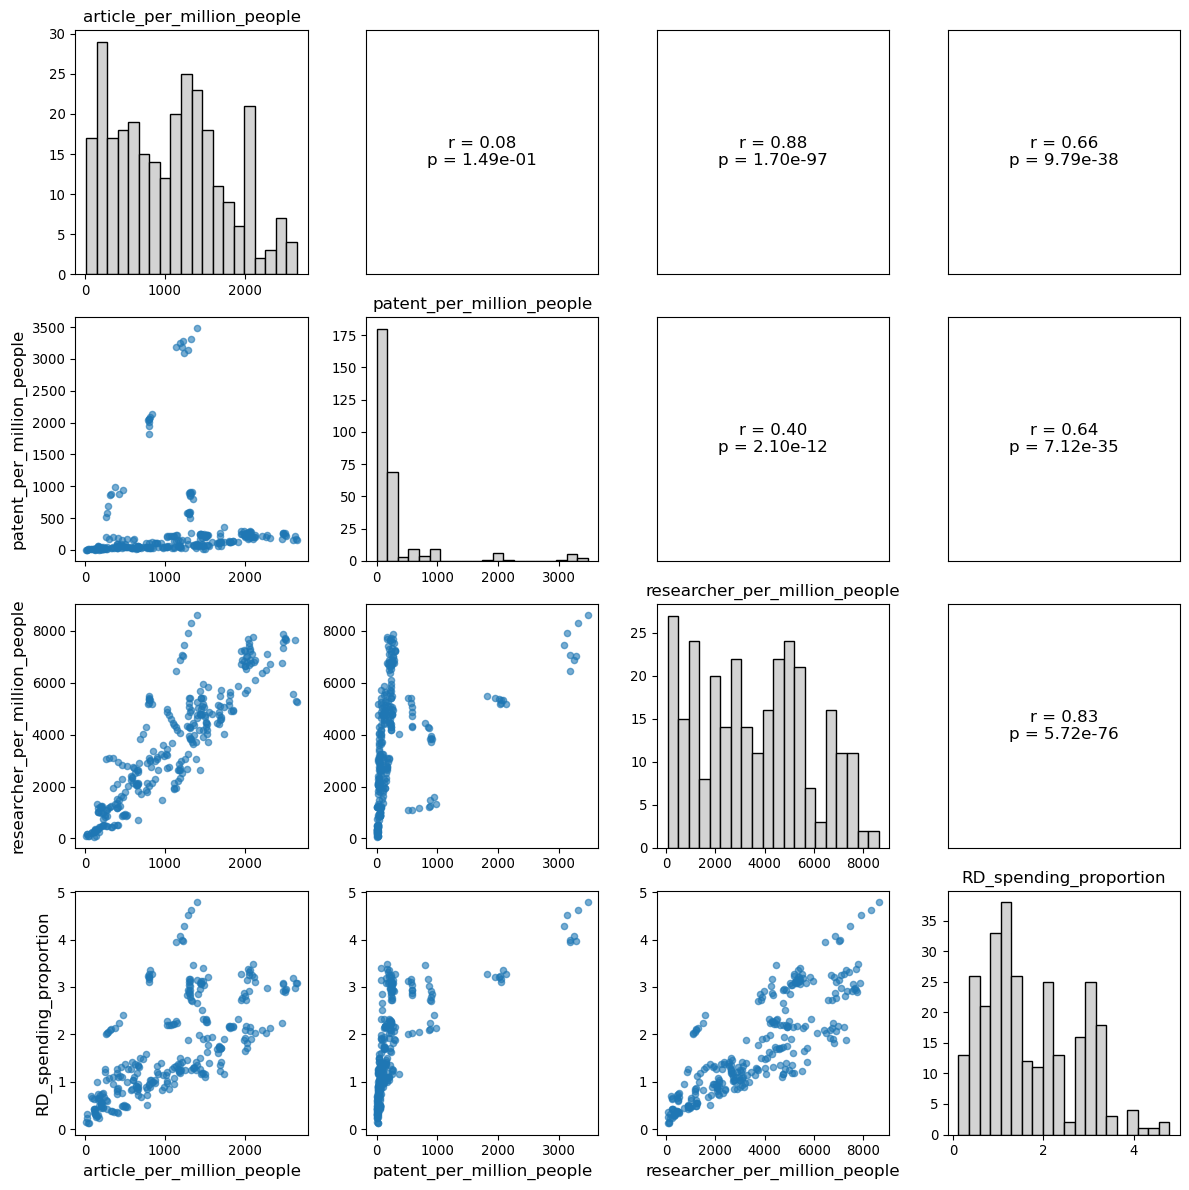

In [10]:
#read data
question_2_data = pd.read_csv("Group_27_Data_2.csv")
question_2_data['Developed_Status'] = question_2_data['Developed_Status'].astype(
        'category')
question_2_data['classification'] = question_2_data['classification'].astype(
        'category')
#select num type data
num_question_2_data=question_2_data[['article_per_million_people','patent_per_million_people','researcher_per_million_people','RD_spending_proportion']].to_numpy()
#plot the correlation between variables
chart_correlation(num_question_2_data,['article_per_million_people','patent_per_million_people','researcher_per_million_people','RD_spending_proportion'])


<<<<Model for article_per_million_people>>>>
--------------------------------------------
                                OLS Regression Results                                
Dep. Variable:     article_per_million_people   R-squared:                       0.837
Model:                                    OLS   Adj. R-squared:                  0.835
Method:                         Least Squares   F-statistic:                     489.8
Date:                        Fri, 07 Mar 2025   Prob (F-statistic):          2.57e-112
Time:                                09:29:29   Log-Likelihood:                -2036.9
No. Observations:                         290   AIC:                             4082.
Df Residuals:                             286   BIC:                             4097.
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                                        

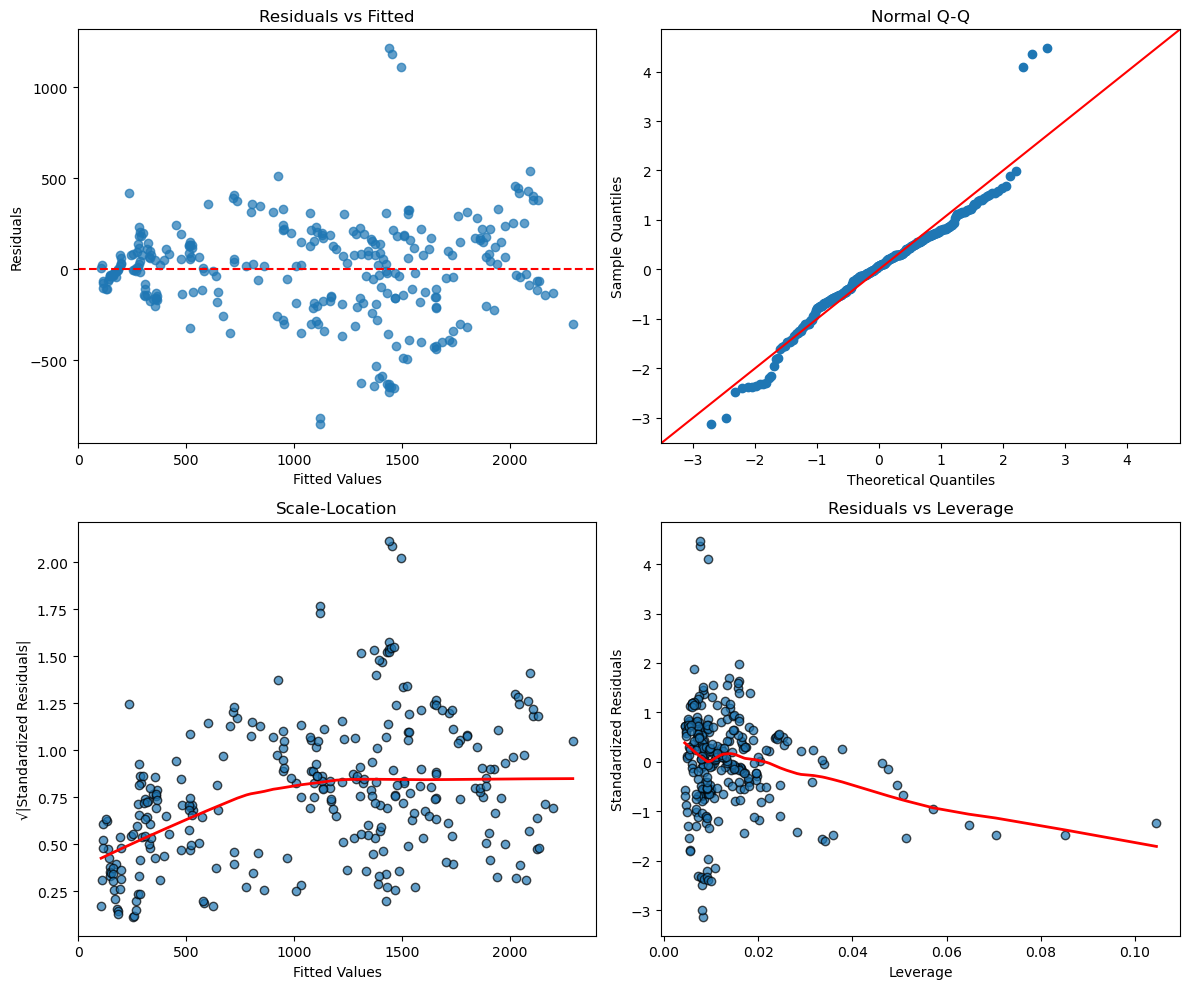

GVIFs computed for predictors
                                   GVIF  Df  GVIF^(1/(2*Df))  \
Developed_Status               5.436053   2         1.526936   
RD_spending_proportion         1.221065   2         1.051198   
researcher_per_million_people  1.000000   3         1.000000   

                                                         Interacts With  \
Developed_Status                          researcher_per_million_people   
RD_spending_proportion                    researcher_per_million_people   
researcher_per_million_people  Developed_Status, RD_spending_proportion   

                                     Other Predictors  
Developed_Status               RD_spending_proportion  
RD_spending_proportion               Developed_Status  
researcher_per_million_people                    --    


In [11]:
predictors = ['RD_spending_proportion', 'researcher_per_million_people', 'Developed_Status',
                  'RD_spending_proportion:researcher_per_million_people',
                  'RD_spending_proportion:Developed_Status',
                  'researcher_per_million_people:Developed_Status',
                  'RD_spending_proportion:researcher_per_million_people:Developed_Status']
#fit model for question 2
model_question_2_article = stepAIC_backward(
        question_2_data, 'article_per_million_people', predictors)
print("<<<<Model for article_per_million_people>>>>")
print("--------------------------------------------")
print(model_question_2_article.summary())
gen_plots(model_question_2_article)
print(mygvif(model_question_2_article))

<<<<Model for patent_per_million_people>>>>
--------------------------------------------
                                OLS Regression Results                               
Dep. Variable:     patent_per_million_people   R-squared:                       0.554
Model:                                   OLS   Adj. R-squared:                  0.544
Method:                        Least Squares   F-statistic:                     58.58
Date:                       Fri, 07 Mar 2025   Prob (F-statistic):           7.75e-47
Time:                               09:29:31   Log-Likelihood:                -2156.3
No. Observations:                        290   AIC:                             4327.
Df Residuals:                            283   BIC:                             4352.
Df Model:                                  6                                         
Covariance Type:                   nonrobust                                         
                                                   

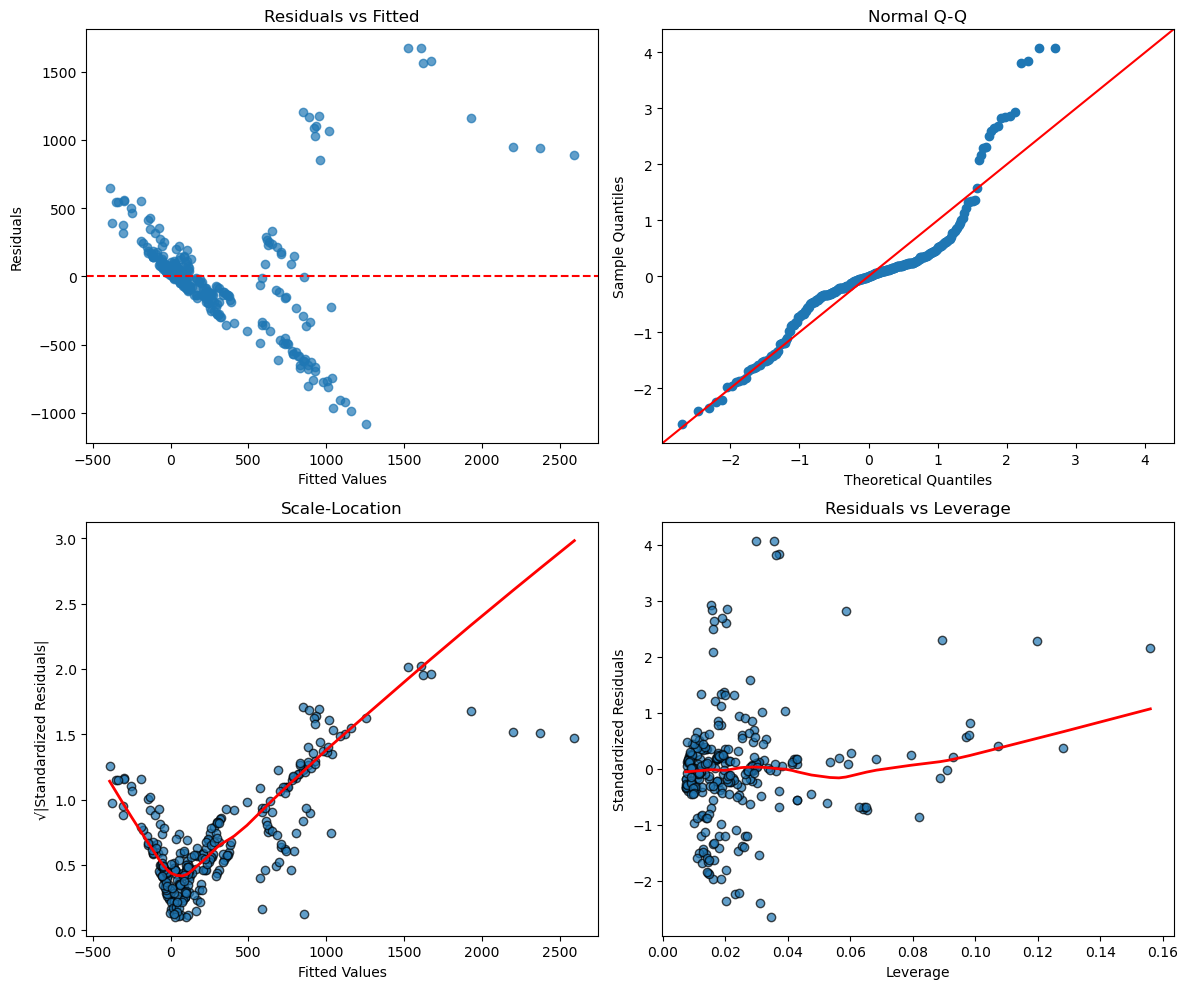

GVIFs computed for predictors
                               GVIF  Df  GVIF^(1/(2*Df))  \
Developed_Status                  1   6                1   
RD_spending_proportion            1   6                1   
researcher_per_million_people     1   6                1   

                                                                  Interacts With  \
Developed_Status               RD_spending_proportion, researcher_per_million...   
RD_spending_proportion           researcher_per_million_people, Developed_Status   
researcher_per_million_people           Developed_Status, RD_spending_proportion   

                              Other Predictors  
Developed_Status                          --    
RD_spending_proportion                    --    
researcher_per_million_people             --    
<<<<Model for patent_per_million_people>>>>
--------------------------------------------
                                OLS Regression Results                               
Dep. Variable:     pa

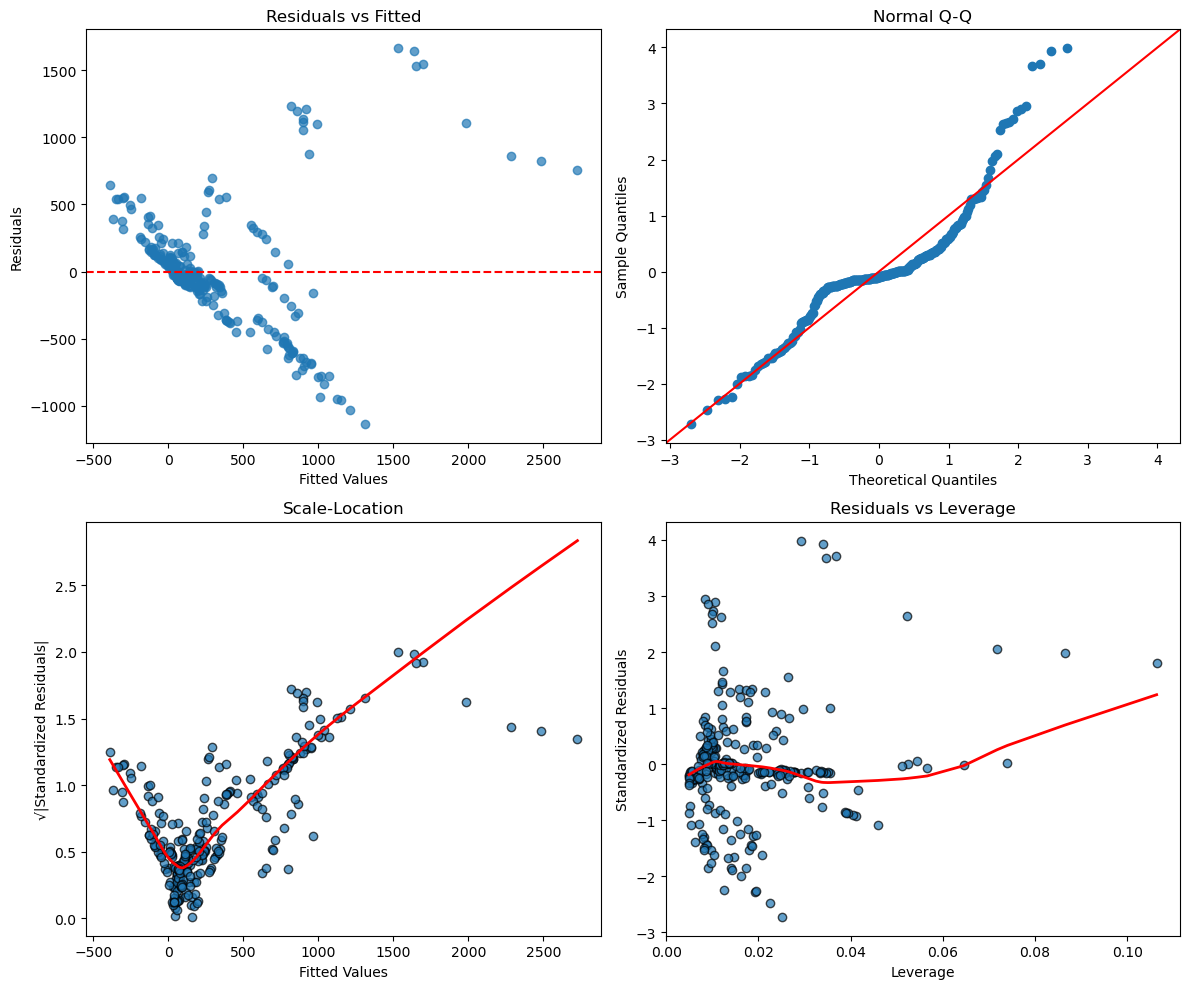

GVIFs computed for predictors
                                   GVIF  Df  GVIF^(1/(2*Df))  \
Developed_Status               6.611207   3         1.369978   
RD_spending_proportion         2.588884   2         1.268464   
researcher_per_million_people  1.000000   4         1.000000   

                                                         Interacts With  \
Developed_Status                          researcher_per_million_people   
RD_spending_proportion                    researcher_per_million_people   
researcher_per_million_people  Developed_Status, RD_spending_proportion   

                                     Other Predictors  
Developed_Status               RD_spending_proportion  
RD_spending_proportion               Developed_Status  
researcher_per_million_people                    --    


In [12]:

model_question_2_patents = stepAIC_both(
        question_2_data, 'patent_per_million_people', predictors)

print("<<<<Model for patent_per_million_people>>>>")
print("--------------------------------------------")
print(model_question_2_patents.summary())
gen_plots(model_question_2_patents)
print(mygvif(model_question_2_patents))

# remove insignificant variables
manual_predictors = ['researcher_per_million_people','Developed_Status',
                         'RD_spending_proportion:researcher_per_million_people', 'researcher_per_million_people:Developed_Status']

model_question_2_patents_manual = fit_model(
        question_2_data, 'patent_per_million_people', manual_predictors)
print("<<<<Model for patent_per_million_people>>>>")
print("--------------------------------------------")
print(model_question_2_patents_manual.summary())
gen_plots(model_question_2_patents_manual)
print(mygvif(model_question_2_patents_manual))


<<<<Model for log_patent_per_million_people>>>>
--------------------------------------------
                                  OLS Regression Results                                 
Dep. Variable:     log_patent_per_million_people   R-squared:                       0.574
Model:                                       OLS   Adj. R-squared:                  0.568
Method:                            Least Squares   F-statistic:                     95.99
Date:                           Fri, 07 Mar 2025   Prob (F-statistic):           1.29e-51
Time:                                   09:29:33   Log-Likelihood:                -390.24
No. Observations:                            290   AIC:                             790.5
Df Residuals:                                285   BIC:                             808.8
Df Model:                                      4                                         
Covariance Type:                       nonrobust                                         
       

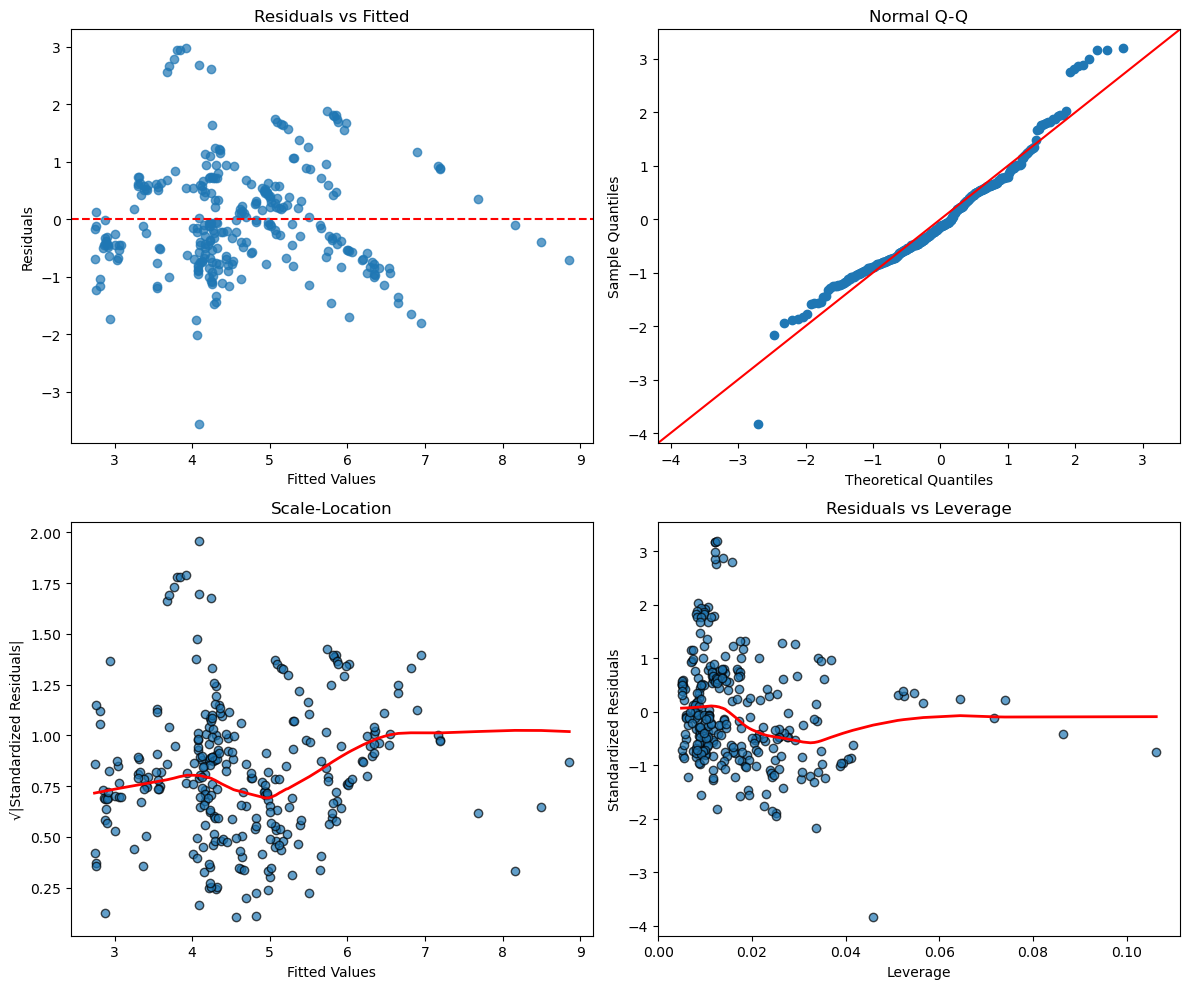

GVIFs computed for predictors
                                   GVIF  Df  GVIF^(1/(2*Df))  \
Developed_Status               6.611207   3         1.369978   
RD_spending_proportion         2.588884   2         1.268464   
researcher_per_million_people  1.000000   4         1.000000   

                                                         Interacts With  \
Developed_Status                          researcher_per_million_people   
RD_spending_proportion                    researcher_per_million_people   
researcher_per_million_people  Developed_Status, RD_spending_proportion   

                                     Other Predictors  
Developed_Status               RD_spending_proportion  
RD_spending_proportion               Developed_Status  
researcher_per_million_people                    --    


In [13]:
question_2_data['log_patent_per_million_people'] = (question_2_data['patent_per_million_people'] + 1).apply(lambda x: np.log(x))

manual_predictors = ['researcher_per_million_people', 'Developed_Status',
                         'RD_spending_proportion:researcher_per_million_people', 'researcher_per_million_people:Developed_Status']
#log transformation for patent_per_million_people
model_question_2_log_patents = fit_model(
        question_2_data, 'log_patent_per_million_people', manual_predictors)
print("<<<<Model for log_patent_per_million_people>>>>")
print("--------------------------------------------")
print(model_question_2_log_patents.summary())
gen_plots(model_question_2_log_patents)
print(mygvif(model_question_2_log_patents))